In [1]:
#!pip install gdown
#!pip install torch==2.1.0 torchvision==0.16.0 --index-url https://download.pytorch.org/whl/cu118

In [2]:
import sys
sys.path.append('..')
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
from src.training import train_model, eval_func
import os
from torchvision import datasets, models, transforms
from src.modelvis import visualize_models

from src.models import ModelResnet152dTimm
from src.dataloader import MiniImageNetDataSet, createMiniImageNetDataLoaders, MiniImageNetDownloader
import torchvision

'''
The line cudnn.benchmark = True is typically used in deep learning projects that utilize the CUDA Deep Neural Network (cuDNN) library.
When cudnn.benchmark is set to True, it enables cuDNN to automatically find the best algorithm configuration for the specific 
input sizes and hardware being used. This can result in improved performance during training and inference.By enabling benchmarking, 
cuDNN will run a short benchmarking phase during the first iteration of the model to determine the optimal algorithm configuration. 
This configuration is then cached and used for subsequent iterations, leading to faster execution times.
It's important to note that enabling benchmarking may introduce some overhead during the initial benchmarking phase, so it is typically 
recommended to use it when the input sizes are consistent throughout the training process.
Overall, setting cudnn.benchmark to True can help optimize the performance of deep learning models that use cuDNN.
'''
torch.backends.cudnn.benchmark = True

'''
The line plt.ion() is a function call that activates interactive mode in matplotlib.
When interactive mode is enabled, any plot that is created will be displayed immediately 
and can be updated dynamically. This means that you can modify the plot after it is displayed, 
such as changing the data or adding annotations, and the changes will be reflected in real-time.
'''
plt.ion()

Device: cuda:0


In [3]:
print(torchvision.__version__)
print(torch.__version__)

0.9.2
1.8.2


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
extractDir = '..\\data\\miniImageNet'
url = 'https://drive.usercontent.google.com/download?id=107FTosYIeBn5QbynR46YG91nHcJ70whs&export=download&authuser=0&confirm=t&uuid=a50f1fb0-d0de-4900-905d-bab7437a3ec8&at=APZUnTXEKGryF0vQqVJF4LvHHCT1:1704557194939'
downloader = MiniImageNetDownloader(url, extractDir)
downloader.download()

2024-01-06 22:35:57,638 - INFO - MiniImageNet database already exists.


In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        transforms.RandomHorizontalFlip(),
        transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]),
}

dataDir = '..\\data\\miniImageNet\\train'
dataloaders, class_names, dataset_sizes = createMiniImageNetDataLoaders(data_transforms, dataDir, split=0.8, batch_size=32)

### Hyperparameters

In [7]:
LEARNING_RATE=0.001 # 0.0001
WEIGHT_DECAY=0.0005 # 0.000001
NUM_EPOCHS=10
BATCH_SIZE=256
MOMENTUM=0.9
STEP_SIZE=7
GAMMA=0.01

In [8]:
NUM_OF_CLASSES = 64
net = ModelResnet152dTimm(NUM_OF_CLASSES)

2024-01-06 22:36:00,744 - INFO - Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet152d_ra2-5cac0439.pth)


### Learning Rate Control

In [9]:
for p in net.parameters():
    p.requires_grad = True
net.train()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params= net.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

Please wait patiently, it may take some minutes...
Epoch 0/9
----------
train Loss: 0.0575 Acc: 0.7355
val Loss: 0.0117 Acc: 0.9107

Epoch 1/9
----------
train Loss: 0.0114 Acc: 0.9067
val Loss: 0.0087 Acc: 0.9276

Epoch 2/9
----------
train Loss: 0.0085 Acc: 0.9261
val Loss: 0.0078 Acc: 0.9320

Epoch 3/9
----------
train Loss: 0.0065 Acc: 0.9427
val Loss: 0.0071 Acc: 0.9398

Epoch 4/9
----------
train Loss: 0.0052 Acc: 0.9545
val Loss: 0.0070 Acc: 0.9404

Epoch 5/9
----------
train Loss: 0.0042 Acc: 0.9625
val Loss: 0.0068 Acc: 0.9430

Epoch 6/9
----------
train Loss: 0.0035 Acc: 0.9688
val Loss: 0.0068 Acc: 0.9417

Epoch 7/9
----------
train Loss: 0.0028 Acc: 0.9758
val Loss: 0.0069 Acc: 0.9440

Epoch 8/9
----------
train Loss: 0.0025 Acc: 0.9779
val Loss: 0.0068 Acc: 0.9445

Epoch 9/9
----------
train Loss: 0.0021 Acc: 0.9824
val Loss: 0.0068 Acc: 0.9458

Training complete in 109m 14s
Best val Acc: 0.945833


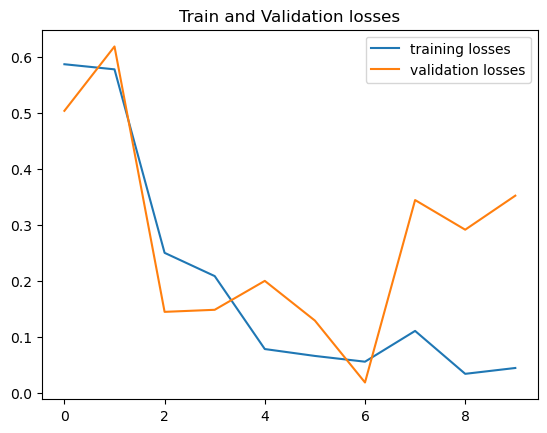

In [10]:
print('Please wait patiently, it may take some minutes...')
best_model = train_model(net, dataloaders, criterion, optimizer, scheduler, NUM_EPOCHS, dataset_sizes)

In [11]:
save_path = '..\\data\\models\\best_model_ModelResnet152dTimm_FixedTransforms.pth'
torch.save(best_model.state_dict(), save_path)

In [12]:
eval_acc = eval_func(best_model, dataloaders['test'])
print('')
print('Accuracy on testing data: %f' % eval_acc)


Accuracy on testing data: 0.947656
